# Homework 1

Choose 2 different time series which represent financial data* (e.g. you can take open stock prices, close stock prices, net income)**. You will analyze and prepare in-sample and out-of-sample forecasts for each of the time series:

-       Perform ADF t`est to check for stationarity (you may also perform KPSS in addition to ADF).

-       Analyze autocorrelation of the time series with Ljung-Box test and ACF, PACF.

-       If the series turns out to be non-stationary, use a proper technique to reduce the series to stationary.

-       For the stationary (or reduced to stationary) series, choose proper ARMA model and build an in-sample forecast and out-of-sample forecast for future 10 periods.

-       If you didn’t have to reduce your time series to stationary – skip this step. Otherwise, for initially non-stationary series, choose proper ARIMA model and build an in-sample forecast and out-of-sample forecast for future 10 periods.

-       Prepare at least 3 useful regressors (both dummy and continuous), choose ARMAX or ARIMAX model and build an in-sample forecast and out-of-sample forecast for future 10 periods.

-       Choose the best model for your time series based on chosen (by you) quality metric.

For each of the chosen time series you can receive up to 5 points: 5 points for the first one and 5 points for the second one. Remember to provide a textual analysis of obtained results and justify all you decision (e.g. answer such questions as: Why have I chosen such ARIMA orders? Why do I think this regressors is useful for my time series? Why have I used differencing to reduce my time series to stationary? Why have I chosen this quality metric for my out-of-sample forecasts? How does my model behave for in-sample forecasts? etc.) In the very end, you should also provide your thoughts on why your chosen best model performed the best in case of this particular time series.

As a result of this homework you should provide a .ipynb file (jupyter notebook) with your code and comments. Also add files with your data (or you can add links and instructions, how to get your data, to your ipynb file).

## Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import yfinance as yf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL, MSTL
from sklearn.metrics import mean_absolute_error

from IPython.display import clear_output
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [2]:
!pip install pmdarima

import pmdarima as pm
from pmdarima import auto_arima
clear_output()

As a quality metric I am going to use **MAE**, because it is in the same units like data and less sensitive to outliers (we have simple models, so it can be crucial).

## Data

I am going to work with **the Apple Inc. stock closing prices** and **the S&P 500 index closing prices** as the two financial time series. Data sourced from Yahoo Finance for the last six years. So, we have 1509 observations from 2018-01-01 up to 2024-01-01.

In [3]:
start_date = '2018-01-01'
end_date = '2024-01-01'
tickers = ['AAPL', '^GSPC']

data_apple = yf.download(['AAPL'], start=start_date, end=end_date, group_by='ticker')
data_sp500 = yf.download(['^GSPC'], start=start_date, end=end_date, group_by='ticker')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
data_apple.head()

Ticker           AAPL                                                       
Price            Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2018-01-02  42.540001  43.075001  42.314999  43.064999  40.524349  102223600
2018-01-03  43.132500  43.637501  42.990002  43.057499  40.517284  118071600
2018-01-04  43.134998  43.367500  43.020000  43.257500  40.705494   89738400
2018-01-05  43.360001  43.842499  43.262501  43.750000  41.168934   94640000
2018-01-08  43.587502  43.902500  43.482498  43.587502  41.016029   82271200

In [5]:
data_sp500.head()

Ticker            ^GSPC                                                      \
Price              Open         High          Low        Close    Adj Close   
Date                                                                          
2018-01-02  2683.729980  2695.889893  2682.360107  2695.810059  2695.810059   
2018-01-03  2697.850098  2714.370117  2697.770020  2713.060059  2713.060059   
2018-01-04  2719.310059  2729.290039  2719.070068  2723.989990  2723.989990   
2018-01-05  2731.330078  2743.449951  2727.919922  2743.149902  2743.149902   
2018-01-08  2742.669922  2748.510010  2737.600098  2747.709961  2747.709961   

Ticker                  
Price           Volume  
Date                    
2018-01-02  3397430000  
2018-01-03  3544030000  
2018-01-04  3697340000  
2018-01-05  3239280000  
2018-01-08  3246160000

In [6]:
aapl_close = data_apple['AAPL']['Close']
gspc_close = data_sp500['^GSPC']['Close']

aapl_close.index = aapl_close.index.date
gspc_close.index = gspc_close.index.date

Let's visualize the data.

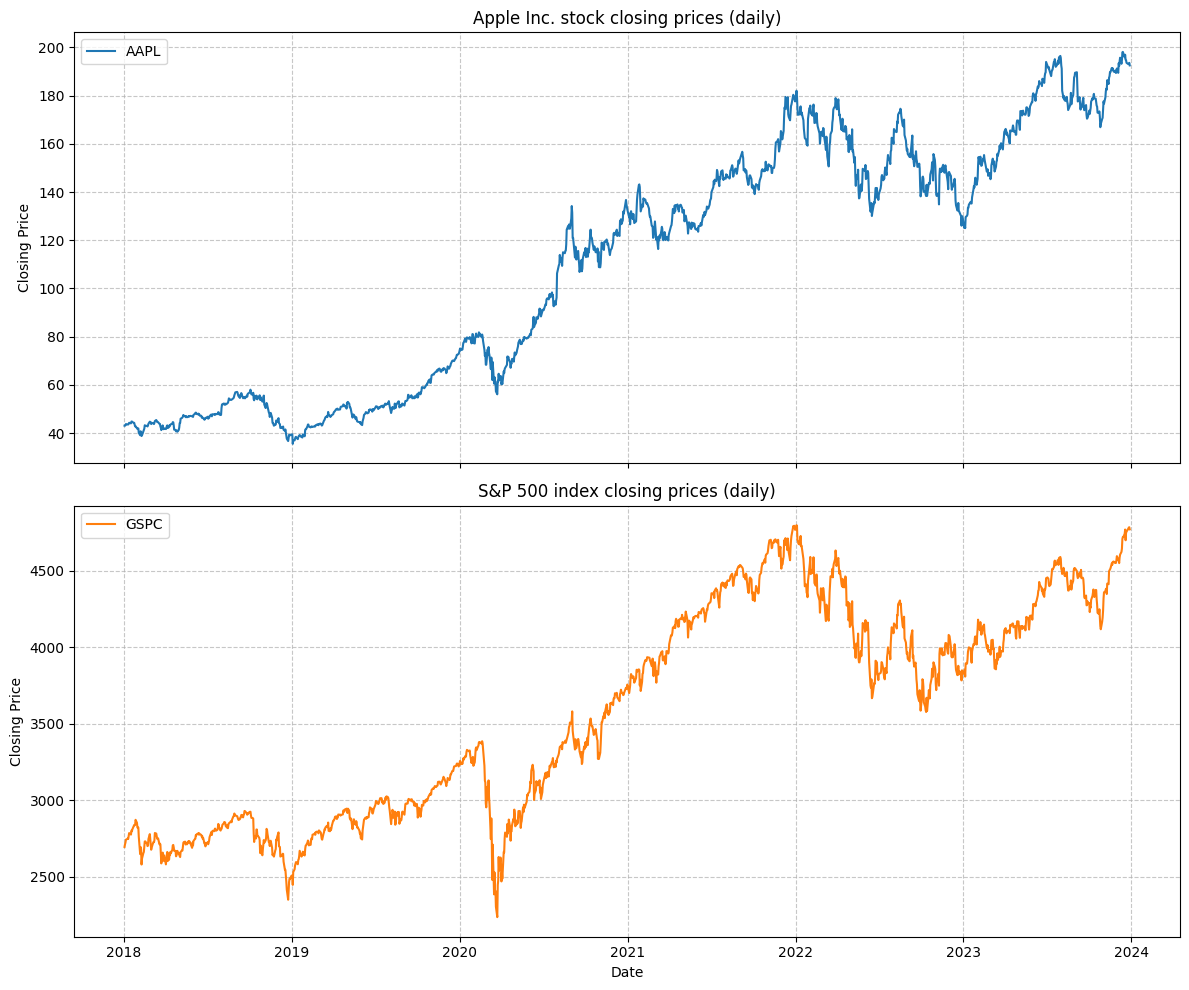

In [7]:
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

axes[0].plot(aapl_close.index, aapl_close.values, label='AAPL')
axes[0].set_title("Apple Inc. stock closing prices (daily)")
axes[0].set_ylabel("Closing Price")
axes[0].grid(True, linestyle='--', alpha=0.7)
axes[0].legend()

axes[1].plot(gspc_close.index, gspc_close.values, label='GSPC', color='tab:orange')
axes[1].set_title("S&P 500 index closing prices (daily)")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Closing Price")
axes[1].grid(True, linestyle='--', alpha=0.7)
axes[1].legend()

plt.tight_layout()
plt.show()

## Stationarity test

Let's check the stationarity of the time series using ADF test. Looking at the graphs of the series, I can assume that they are non-stationary.

In [8]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

In [9]:
print("ADF Test for Apple's Closing Prices:")
adf_test(aapl_close)

ADF Test for Apple's Closing Prices:
Results of Dickey-Fuller Test:
Test Statistic                   -0.548308
p-value                           0.882240
#Lags Used                        1.000000
Number of Observations Used    1507.000000
Critical Value (1%)              -3.434697
Critical Value (5%)              -2.863460
Critical Value (10%)             -2.567792
dtype: float64


<font color='red'>**p-value > significance level (default: 0.05)**</font> => we accept H(0) and our ts is non-stationary (ADF).

In [10]:
print("ADF Test for S&P 500 Index:")
adf_test(gspc_close)

ADF Test for S&P 500 Index:
Results of Dickey-Fuller Test:
Test Statistic                   -0.808789
p-value                           0.816527
#Lags Used                       10.000000
Number of Observations Used    1498.000000
Critical Value (1%)              -3.434723
Critical Value (5%)              -2.863471
Critical Value (10%)             -2.567798
dtype: float64


<font color='red'>**p-value > significance level (default: 0.05)**</font> => we accept H(0) and our ts is non-stationary (ADF).

So, both of our ts are non-stationary based on ADF test.

## Analyze autocorrelation

I am going to use Ljung-Box test and ACF, PACF to check the autocorrelation. Let's first the Apple prices.

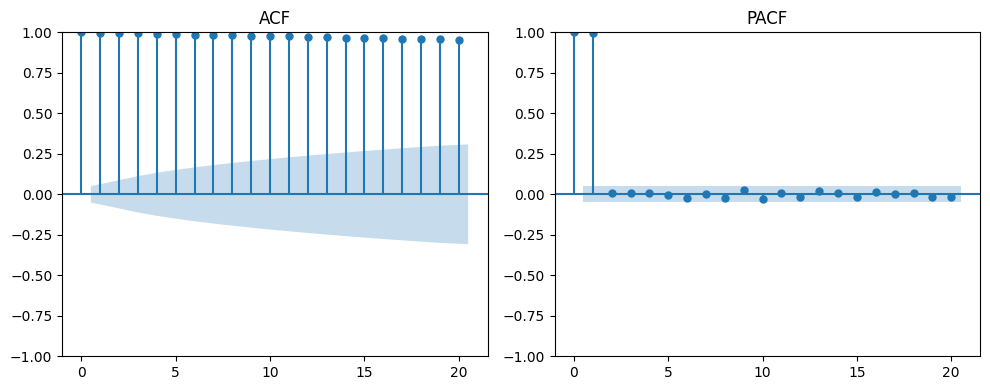

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# ACF
plot_acf(aapl_close.dropna(), ax=ax[0], lags=20)
ax[0].set_title('ACF')

# PACF
plot_pacf(aapl_close.dropna(), ax=ax[1], lags=20)
ax[1].set_title('PACF')

plt.tight_layout()
plt.show()

The ACF declines very slowly and remains significant for all lags (correlation bars are outside the blue region). This suggests a strong and persistent autocorrelation in out ts. The PACF shows a significant spike at lag = 1 and no significant spikes at higher lags.

Let's check Ljung-Box test.

In [12]:
acorr_ljungbox(aapl_close.dropna(), return_df=True)

,lb_stat,lb_pvalue
1,1504.824991,0.0
2,3003.630056,0.0
3,4496.586725,0.0
4,5983.800291,0.0
5,7465.253197,0.0
6,8940.662633,0.0
7,10410.124913,0.0
8,11873.347868,0.0
9,13330.762918,0.0
10,14781.955490,0.0


Based on Ljung-Box test we get strong autocorrelation.  All tests suggest that our ts is likely non-stationary and we need preprocessing (differencing).

Let's go for the S&P 500 data.

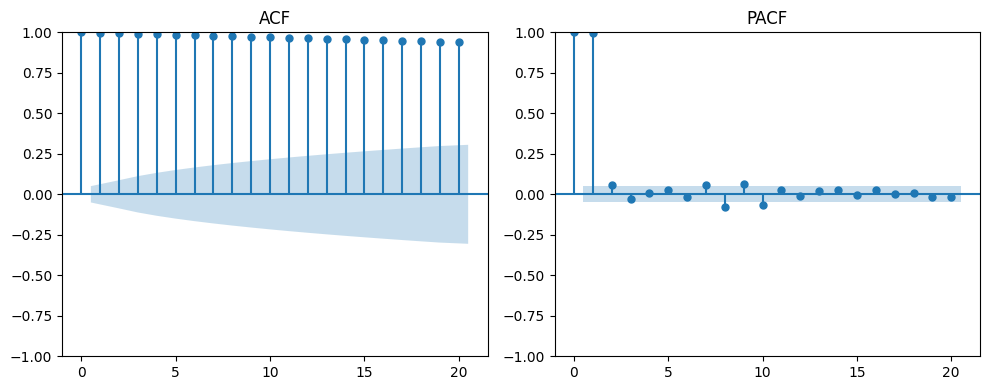

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# ACF
plot_acf(gspc_close.dropna(), ax=ax[0], lags=20)
ax[0].set_title('ACF')

# PACF
plot_pacf(gspc_close.dropna(), ax=ax[1], lags=20)
ax[1].set_title('PACF')

plt.tight_layout()
plt.show()

In [14]:
acorr_ljungbox(gspc_close.dropna(), return_df=True)

,lb_stat,lb_pvalue
1,1501.463160,0.0
2,2994.605178,0.0
3,4478.761020,0.0
4,5954.242059,0.0
5,7421.646760,0.0
6,8880.600686,0.0
7,10332.417861,0.0
8,11775.418860,0.0
9,13211.125374,0.0
10,14637.957021,0.0


In the ACF graph the autocorrelation is very high at lag 1 and remains significant for all subsequent lags. This again indicates strong correlation between our ts and its past values. In the PACF graph, only the first 1 or 2 lags are significant and the remaining lags are close to zero. Ljung-Box test also tells us that our data exhibits significant autocorrelation at all lags.

##Differencing

Differencing is a common technique used to make a time series stationary by removing trends or seasonality. It is particularly useful when the data show patterns that change over time, such as rising or falling trends - which is exactly what we see in our data.

**Formula** (1st order)

$ΔY_t = Y_t - Y_{t-1}$ or $y'_t = y_t - y_{t-1}$

In [15]:
aapl_diff = aapl_close.diff()
aapl_diff.tail()

,Close
2023-12-22,-1.079987
2023-12-26,-0.550003
2023-12-27,0.099991
2023-12-28,0.430008
2023-12-29,-1.050003


In [16]:
gspc_diff = gspc_close.diff()[:-1]
gspc_diff.tail()

,Close
2023-12-21,48.399902
2023-12-22,7.879883
2023-12-26,20.120117
2023-12-27,6.830078
2023-12-28,1.770020


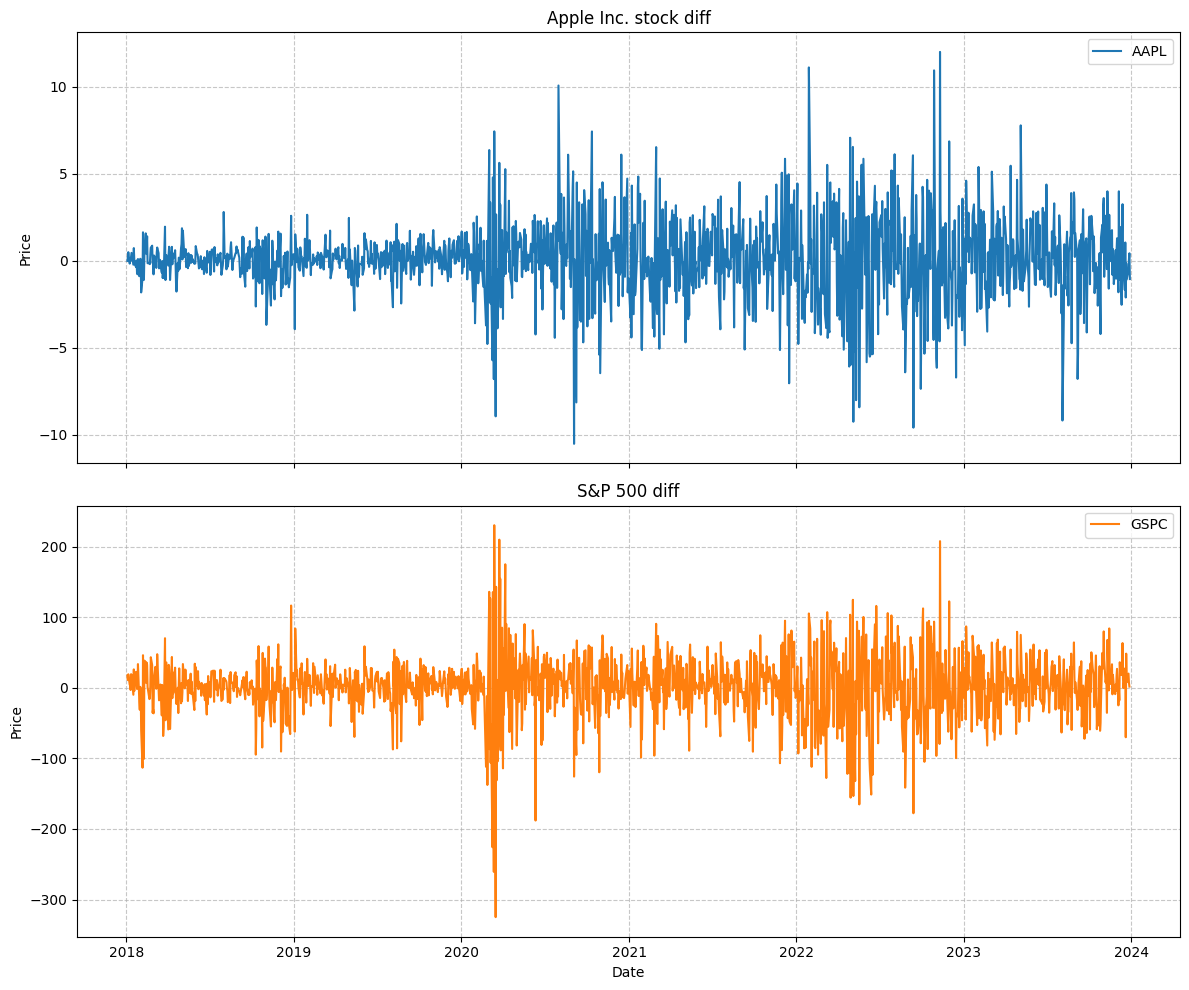

In [17]:
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

axes[0].plot(aapl_diff.dropna().index, aapl_diff.dropna().values, label='AAPL')
axes[0].set_title("Apple Inc. stock diff")
axes[0].set_ylabel("Price")
axes[0].grid(True, linestyle='--', alpha=0.7)
axes[0].legend()

axes[1].plot(gspc_diff.dropna().index, gspc_diff.dropna().values, label='GSPC', color='tab:orange')
axes[1].set_title("S&P 500 diff")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Price")
axes[1].grid(True, linestyle='--', alpha=0.7)
axes[1].legend()

plt.tight_layout()
plt.show()

These pictures look more like stationary ts. Let's check it using ADF test.

In [18]:
print("ADF Test for Apple's diff Closing Prices:")
adf_test(aapl_diff.dropna())

ADF Test for Apple's diff Closing Prices:
Results of Dickey-Fuller Test:
Test Statistic                  -40.359844
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    1507.000000
Critical Value (1%)              -3.434697
Critical Value (5%)              -2.863460
Critical Value (10%)             -2.567792
dtype: float64


<font color='green'>**p-value <= significance level (default: 0.05)**</font> => we reject H(0) and our ts is stationary (ADF).

In [19]:
print("ADF Test for S&P 500 diff:")
adf_test(gspc_diff.dropna())

ADF Test for S&P 500 diff:
Results of Dickey-Fuller Test:
Test Statistic                -1.197266e+01
p-value                        3.865945e-22
#Lags Used                     9.000000e+00
Number of Observations Used    1.497000e+03
Critical Value (1%)           -3.434726e+00
Critical Value (5%)           -2.863473e+00
Critical Value (10%)          -2.567799e+00
dtype: float64


<font color='green'>**p-value <= significance level (default: 0.05)**</font> => we reject H(0) and our ts is stationary (ADF).

Hooray, both of our ts are now stationary!

## Forecasting

Here we need to choose proper ARMA model, so we need to make ACF and PACF tests.

###Apple

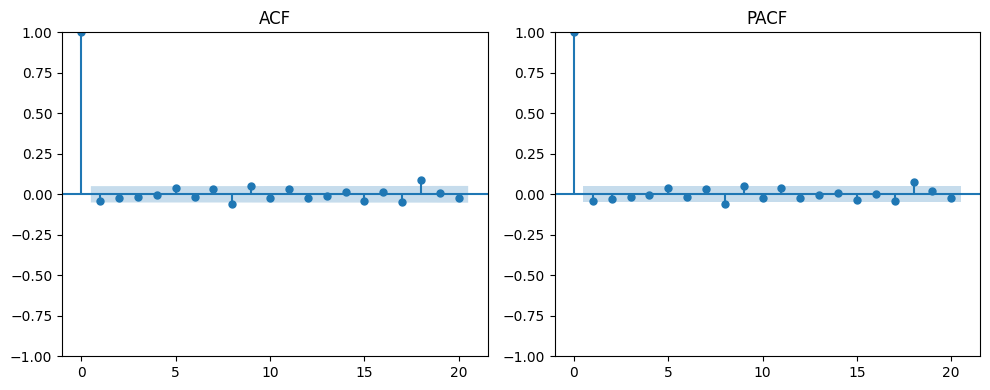

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# ACF
plot_acf(aapl_diff.dropna(), ax=ax[0], lags=20)
ax[0].set_title('ACF')

# PACF
plot_pacf(aapl_diff.dropna(), ax=ax[1], lags=20)
ax[1].set_title('PACF')

plt.tight_layout()
plt.show()

Ok, here wa can see sharp cutoff after lag=0, so we can use ARMA(0,0) model - a white noise model, but it means that there is no structure at all (no AR or MA components). I believe that here we have some structure, so my suggestion is to use ARMA(0,1).

We can also check out hypothesis using classical grid search on ARMA parameters on AIC and BIC (lower is better).

In [21]:
best_params = []
for p in np.arange(0,3):
  for q in np.arange(0,3):
    model = ARIMA(aapl_diff, order=(p,0,q)).fit()
    best_params.append({'p':p, 'q':q, 'AIC':model.aic, 'BIC':model.bic})

pd.DataFrame(best_params).sort_values(by='AIC').head()

,p,q,AIC,BIC
1,0,1,6677.449790,6693.407397
3,1,0,6677.578127,6693.535734
0,0,0,6677.946291,6688.584696
4,1,1,6678.460247,6699.737056
2,0,2,6678.468284,6699.745094


So, I was right, we need ARMA(0,1). Let's firstle make in-sample forecasting (test is the part of training) for future 10 periods.

In [22]:
model = ARIMA(aapl_diff, order=(0,0,1)) # orders are (p,d,q), p - AR, q - MA
model = model.fit()
forecast = model.predict()

print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1509
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -3335.725
Date:                Sun, 22 Dec 2024   AIC                           6677.450
Time:                        14:22:04   BIC                           6693.407
Sample:                             0   HQIC                          6683.393
                               - 1509                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0991      0.055      1.815      0.070      -0.008       0.206
ma.L1         -0.0418      0.019     -2.250      0.024      -0.078      -0.005
sigma2         4.8849      0.110     44.248      0.0

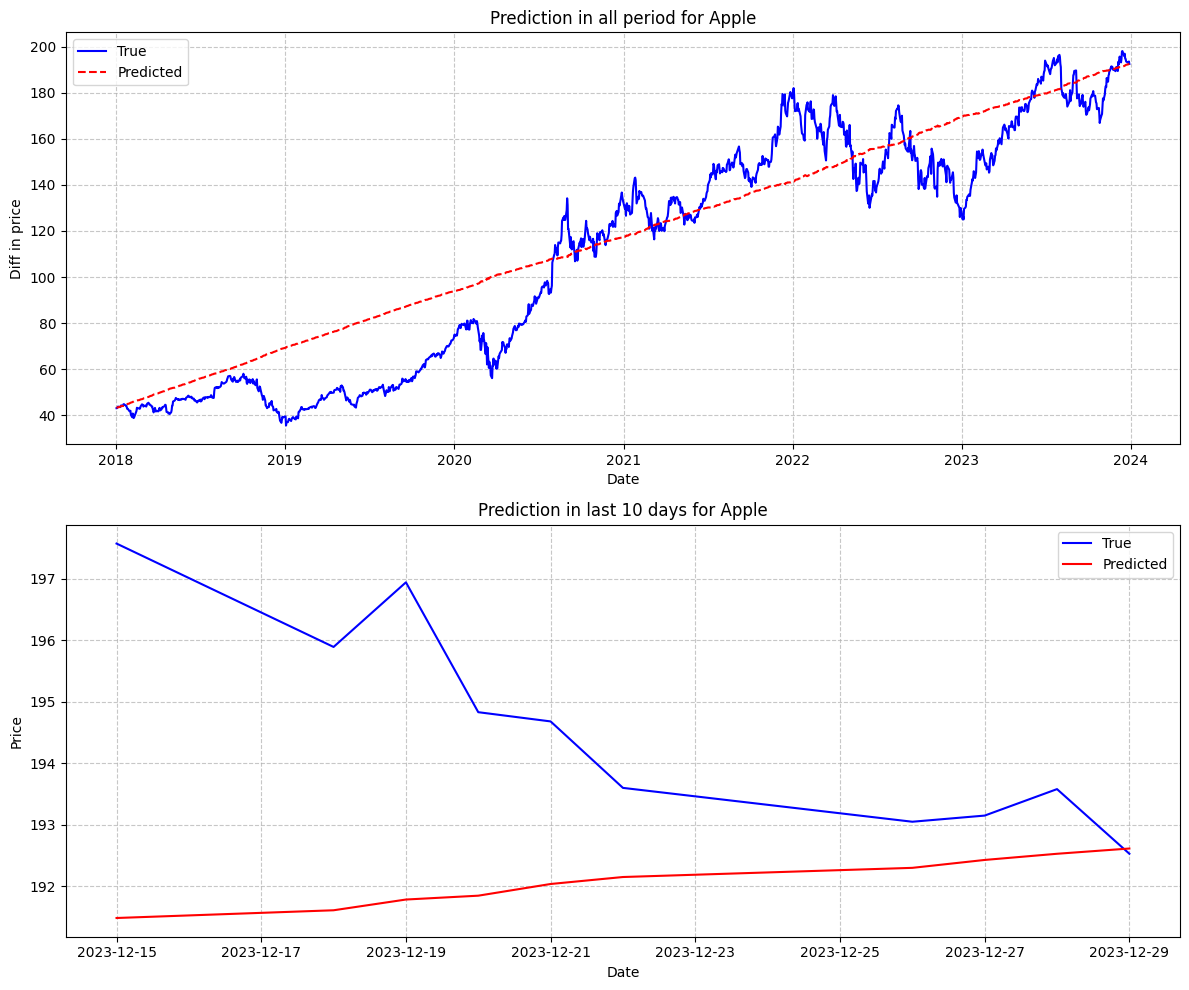

In [23]:
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

y_0 = aapl_close[0]
restored = np.cumsum(forecast.values)+y_0

axes[0].plot(aapl_close.dropna().index, aapl_close.dropna().values, 'b', label='True')
axes[0].plot(aapl_close.dropna().index, restored, 'r--', label="Predicted")
axes[0].set_title("Prediction in all period for Apple")
axes[0].set_ylabel("Diff in price")
axes[0].set_xlabel("Date")
axes[0].grid(True, linestyle='--', alpha=0.7)
axes[0].legend()

axes[1].plot(aapl_close[-10:].dropna().index, aapl_close[-10:].dropna().values, color='blue', label='True')
axes[1].plot(aapl_close[-10:].dropna().index, restored[-10:], color='red', label="Predicted")
axes[1].set_title("Prediction in last 10 days for Apple")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Price")
axes[1].grid(True, linestyle='--', alpha=0.7)
axes[1].legend()

plt.tight_layout()
plt.show()

In [24]:
print(f"MAE for 10 last samples = {mean_absolute_error(restored[-10:], aapl_close[-10:])}")

MAE for 10 last samples = 2.5193643315619028


Yeah, that's not pretty bad for the first try. Now, let's make out-of-sample forecasts.

In [25]:
test_size = 10
train, test = aapl_diff[:-test_size], aapl_diff[-test_size:]

train.size, test.size

(1499, 10)

In [26]:
model = ARIMA(train, order=(0,0,1)) # orders are (p,d,q), p - AR, q - MA
model = model.fit()

print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1499
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -3317.306
Date:                Sun, 22 Dec 2024   AIC                           6640.611
Time:                        14:22:08   BIC                           6656.549
Sample:                             0   HQIC                          6646.549
                               - 1499                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1035      0.055      1.883      0.060      -0.004       0.211
ma.L1         -0.0417      0.019     -2.234      0.025      -0.078      -0.005
sigma2         4.9091      0.112     44.012      0.0

In [27]:
predicted = model.forecast(steps=test_size)
predicted = pd.DataFrame(predicted)
predicted['Date'] = test.index
predicted = predicted.set_index('Date')
predicted

,predicted_mean
Date,
2023-12-15,0.095996
2023-12-18,0.103496
2023-12-19,0.103496
2023-12-20,0.103496
2023-12-21,0.103496
2023-12-22,0.103496
2023-12-26,0.103496
2023-12-27,0.103496
2023-12-28,0.103496


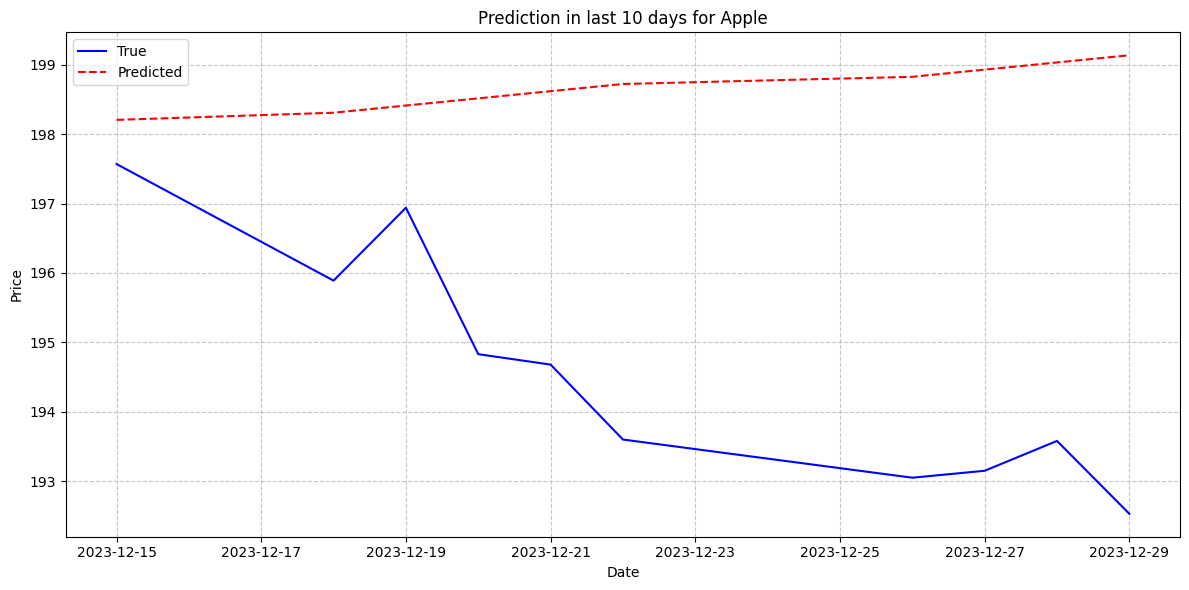

In [28]:
y_0 = aapl_close[-11]
restored = np.cumsum(predicted.values)+y_0

plt.figure(figsize=(12, 6))
plt.plot(aapl_close[-10:].dropna().index, aapl_close[-10:].dropna().values, 'b', label='True')
plt.plot(aapl_close[-10:].dropna().index, restored, 'r--', label="Predicted")
plt.title("Prediction in last 10 days for Apple")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.tight_layout()
plt.show()

In [29]:
print(f"MAE for 10 last samples = {mean_absolute_error(restored, aapl_close[-10:])}")

MAE for 10 last samples = 4.089727628260723


We have here classical situation. Out-of-sample forecasts with MA models eventually converge to the series mean for longer horizons because they rely on lagged errors, which become unavailable beyond the observed data.

Also MAE is worse that for in-sample, two times worse.

###S&P 500

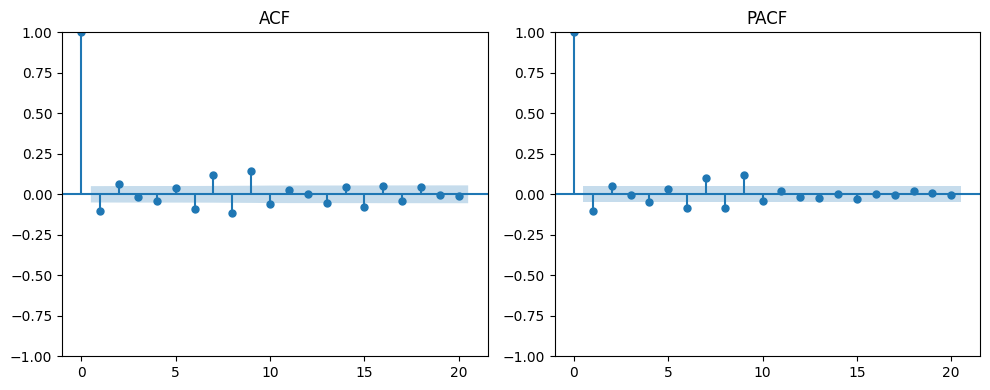

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# ACF
plot_acf(gspc_diff.dropna(), ax=ax[0], lags=20)
ax[0].set_title('ACF')

# PACF
plot_pacf(gspc_diff.dropna(), ax=ax[1], lags=20)
ax[1].set_title('PACF')

plt.tight_layout()
plt.show()

Hmmm, interesting, here is rather hard to predict. I suggest to check p and q using previous grid search (too big values can cause overfitting).

In [31]:
best_params = []
for p in np.arange(0,3):
  for q in np.arange(0,3):
    model = ARIMA(gspc_diff.dropna(), order=(p,0,q)).fit()
    best_params.append({'p':p, 'q':q, 'AIC':model.aic, 'BIC':model.bic})

pd.DataFrame(best_params).sort_values(by='AIC').head()

,p,q,AIC,BIC
8,2,2,15576.315063,15608.222320
6,2,0,15629.668978,15650.940483
2,0,2,15629.831577,15651.103081
4,1,1,15630.813499,15652.085004
5,1,2,15631.349367,15657.938748


So, the best model is ARMA(2,2).

In [32]:
model = ARIMA(gspc_diff, order=(2,0,2)) # orders are (p,d,q), p - AR, q - MA
model = model.fit()
forecast = model.predict()

print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1508
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -7782.158
Date:                Sun, 22 Dec 2024   AIC                          15576.315
Time:                        14:22:25   BIC                          15608.226
Sample:                             0   HQIC                         15588.200
                               - 1508                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3859      1.079      1.284      0.199      -0.730       3.502
ar.L1         -1.7615      0.025    -69.213      0.000      -1.811      -1.712
ar.L2         -0.8855      0.024    -37.187      0.0

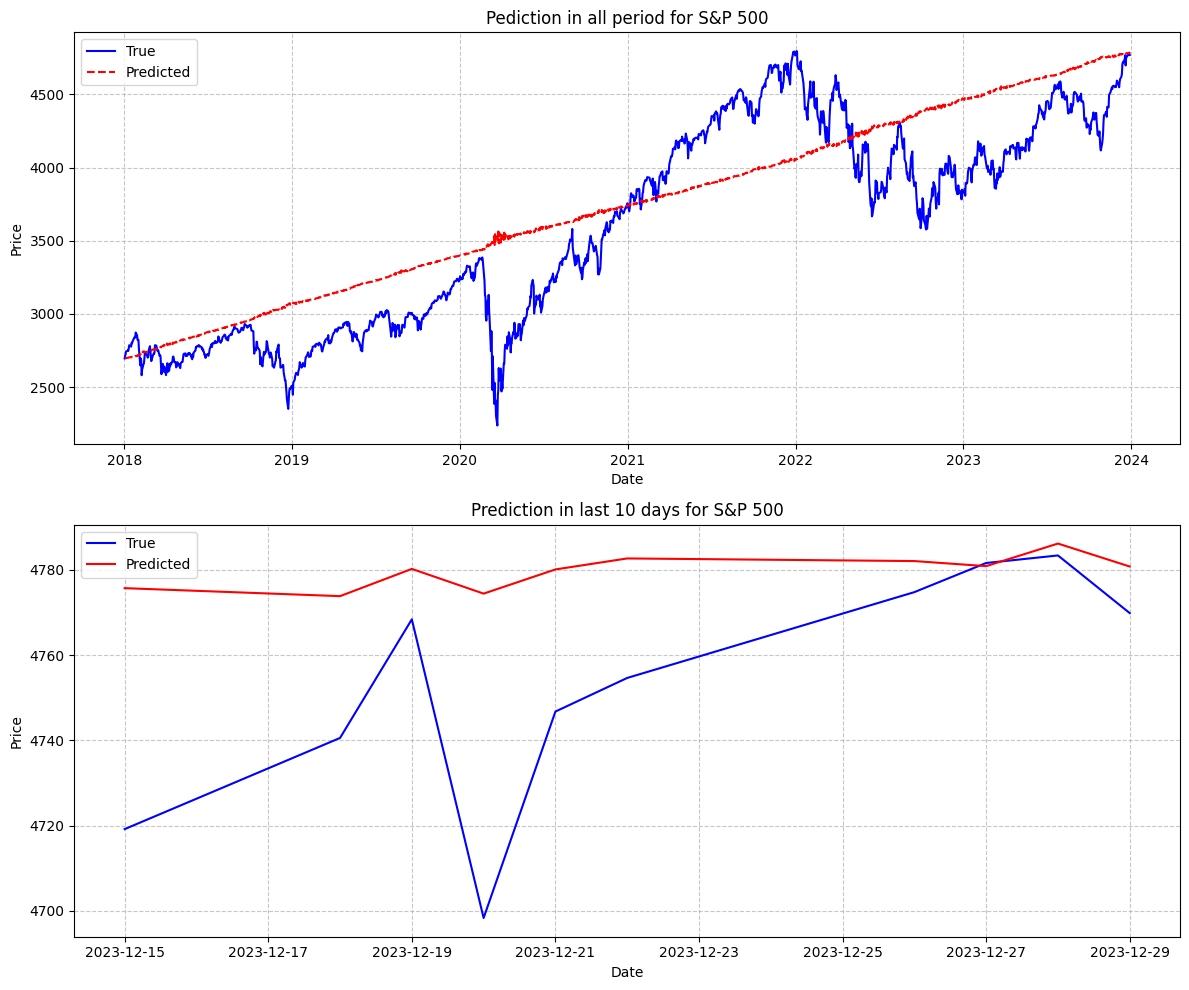

In [33]:
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

y_0 = gspc_close[0]
restored = np.cumsum(forecast.values)+y_0

axes[0].plot(gspc_close.dropna().index, gspc_close.dropna().values, color='blue', label='True')
axes[0].plot(gspc_close[1:].dropna().index, restored, 'r--', label="Predicted")
axes[0].set_title("Pediction in all period for S&P 500")
axes[0].set_ylabel("Price")
axes[0].set_xlabel("Date")
axes[0].grid(True, linestyle='--', alpha=0.7)
axes[0].legend()

axes[1].plot(gspc_close[-10:].dropna().index, gspc_close[-10:].dropna().values, color='blue', label='True')
axes[1].plot(gspc_close[-10:].dropna().index, restored[-10:], color='red', label="Predicted")
axes[1].set_title("Prediction in last 10 days for S&P 500")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Price")
axes[1].grid(True, linestyle='--', alpha=0.7)
axes[1].legend()

plt.tight_layout()
plt.show()

In [34]:
print(f"MAE for 10 last samples = {mean_absolute_error(restored[-10:], gspc_close[-10:])}")

MAE for 10 last samples = 26.068435752560163


Wow, first results for S&P 500 close prices. Now, let's make out-of-sample forecasts.

In [35]:
test_size = 10
train, test = gspc_diff[:-test_size], gspc_diff[-test_size:]

train.size, test.size

(1498, 10)

In [36]:
model = ARIMA(train, order=(2,0,2)) # orders are (p,d,q), p - AR, q - MA
model = model.fit()

print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1498
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -7732.744
Date:                Sun, 22 Dec 2024   AIC                          15477.488
Time:                        14:22:29   BIC                          15509.360
Sample:                             0   HQIC                         15489.362
                               - 1498                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3406      1.085      1.236      0.216      -0.785       3.467
ar.L1         -1.7639      0.025    -70.060      0.000      -1.813      -1.715
ar.L2         -0.8875      0.024    -37.684      0.0

In [37]:
predicted = model.forecast(steps=test_size)
predicted = pd.DataFrame(predicted)
predicted['Date'] = test.index
predicted = predicted.set_index('Date')
predicted

,predicted_mean
Date,
2023-12-14,0.814178
2023-12-15,-1.099279
2023-12-18,6.111595
2023-12-19,-4.909395
2023-12-20,8.130879
2023-12-21,-5.089802
2023-12-22,6.657037
2023-12-26,-2.330011
2023-12-27,3.097087


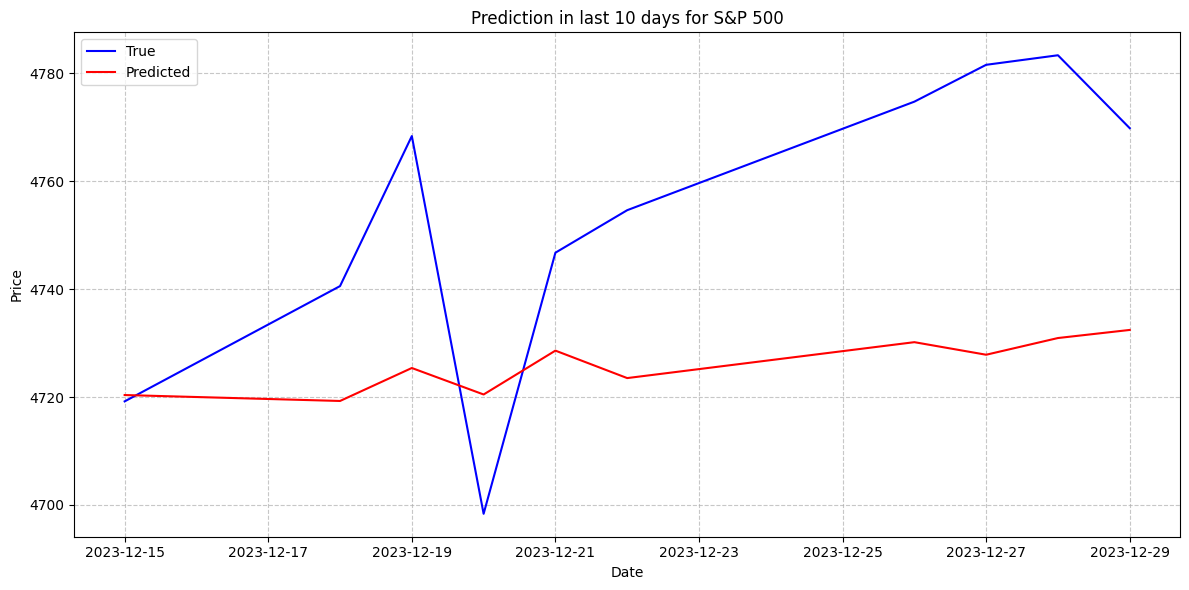

In [38]:
y_0 = gspc_close[-11]
restored = np.cumsum(predicted.values)+y_0

plt.figure(figsize=(12, 6))
plt.plot(gspc_close[-10:].dropna().index, gspc_close[-10:].dropna().values, color='blue', label='True')
plt.plot(gspc_close[-10:].dropna().index, restored, color='red', label="Predicted")
plt.title("Prediction in last 10 days for S&P 500")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.tight_layout()
plt.show()

In [39]:
print(f"MAE for 10 last samples = {mean_absolute_error(restored[-10:], gspc_close[-10:])}")

MAE for 10 last samples = 32.50000943439345


Ok, also not very good prediction: we can't guess the trends (it is opposite to real trends :( ). Also again MAE is bigger than for in-sample prediction.

## Forecasting original data

###Apple

Based on autocorrelation part of this notebook we can make several conclusions. The ACF plot's extremely slow decay strongly indicates non-stationarity, necessitating differencing with d=1 (we check that the difference gives us stationarity). The PACF suggests an AR(1) component with p=1 due to the significant spike at lag 1 followed by a sharp cutoff. Given the slow ACF decay, an initial q=0 is reasonable, leading to an ARIMA(1,1,0) as a starting point for model fitting and further refinement.

It's my assumptions. Let's check them using auto ARIMA. Firstly, for in-sample forecast.

In [40]:
model = auto_arima(aapl_close, stepwise=True, trace=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6682.359, Time=0.87 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6677.946, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6677.578, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6677.450, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6678.971, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6678.460, Time=2.35 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=6678.468, Time=1.30 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6680.324, Time=1.15 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=6678.743, Time=0.10 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 6.469 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1509
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -3335.725
Date:                Sun, 22 Dec 2024   AIC      

Ohh, I was close, but the best is ARIMA(0,1,1). Ok, let's plot results.

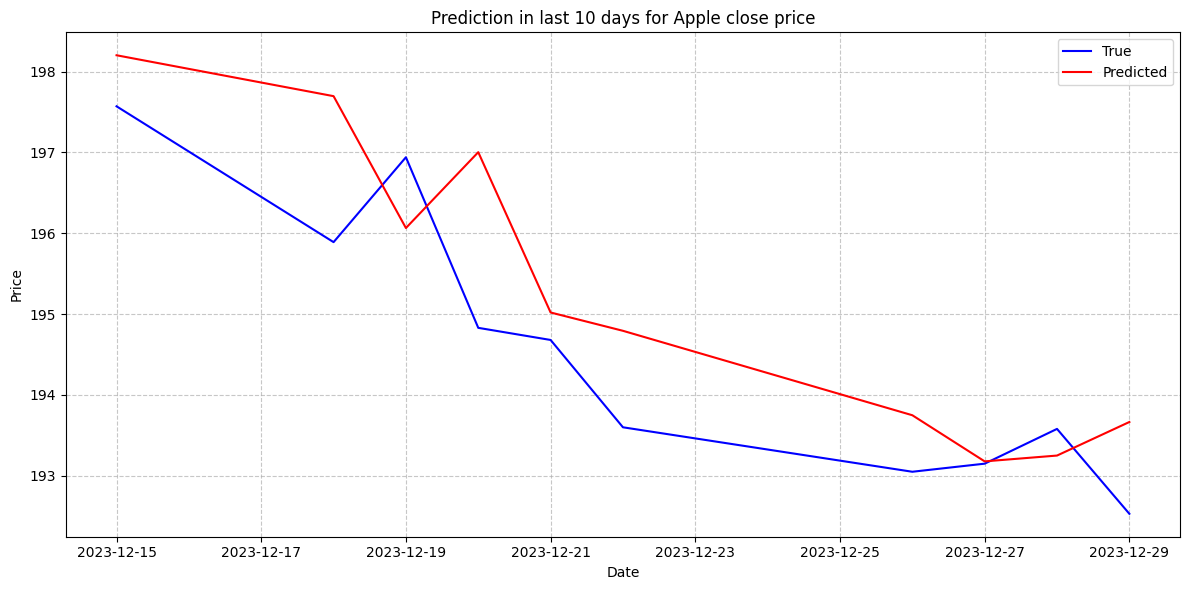

In [41]:
forecast_auto_arima_apple = model.predict_in_sample(start=len(aapl_close)-10, end=len(aapl_close)-1)

plt.figure(figsize=(12, 6))
plt.plot(aapl_close[-10:].dropna().index, aapl_close[-10:].dropna().values, color='blue', label='True')
plt.plot(aapl_close[-10:].dropna().index, forecast_auto_arima_apple.dropna().values, color='red', label="Predicted")
plt.title("Prediction in last 10 days for Apple close price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.tight_layout()
plt.show()

In [42]:
print(f"MAE for 10 last samples = {mean_absolute_error(forecast_auto_arima_apple, aapl_close[-10:])}")

MAE for 10 last samples = 0.9210609763754235


Rather good results!
Let's go to out-of-sample forecasts.

In [43]:
test_size = 10
train, test = aapl_close[:-test_size], aapl_close[-test_size:]

train.size, test.size

(1499, 10)

In [44]:
model = auto_arima(train, stepwise=True, trace=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6645.491, Time=0.91 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6641.078, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6640.740, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6640.611, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6642.337, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6641.608, Time=0.75 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=6641.596, Time=0.42 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6643.459, Time=0.85 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=6642.156, Time=0.11 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 3.588 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1499
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -3317.306
Date:                Sun, 22 Dec 2024   AIC      

 Again ARIMA(0,1,1) is the best. Ok, let's plot results.

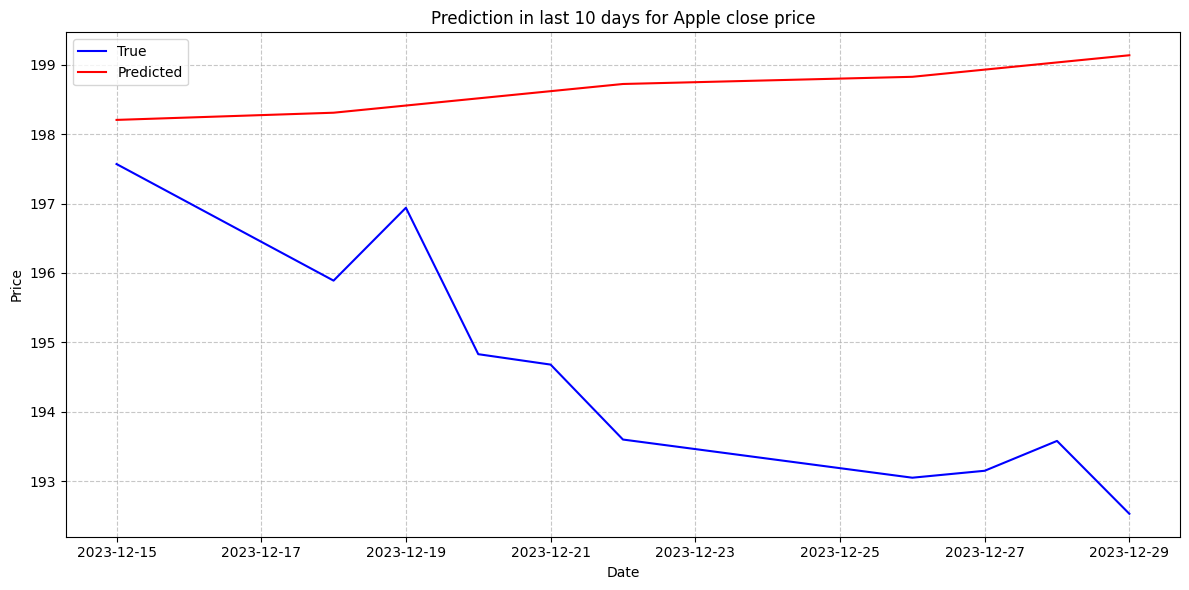

In [45]:
forecast_auto_arima_apple = model.predict()

plt.figure(figsize=(12, 6))
plt.plot(aapl_close[-10:].dropna().index, aapl_close[-10:].dropna().values, color='blue', label='True')
plt.plot(aapl_close[-10:].dropna().index, forecast_auto_arima_apple.dropna().values, color='red', label="Predicted")
plt.title("Prediction in last 10 days for Apple close price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.tight_layout()
plt.show()

In [46]:
print(f"MAE for 10 last samples = {mean_absolute_error(forecast_auto_arima_apple, aapl_close[-10:])}")

MAE for 10 last samples = 4.089719374020646


Again not good for out-of-sample :).

###S&P 500

Here we have the similar ACF and PACF as for Apple prices. So, I can suggest to use ARIMA(1,1,0) (but again ARIMA(0,1,1) may win :)).

In [47]:
model = auto_arima(gspc_close, stepwise=True, trace=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=15585.944, Time=2.91 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=15654.834, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=15641.114, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=15642.666, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=15654.348, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=15640.851, Time=0.95 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=15641.150, Time=1.88 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=15587.364, Time=5.26 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=15643.357, Time=3.84 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=15640.306, Time=1.07 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=15641.574, Time=2.17 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=15642.325, Time=4.83 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=15588.639, Time=4.47 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=15585.689, Time=1.11 sec
 ARIMA(1,1,2)(0,0,0

No, this time ARIMA(2,1,2) won.

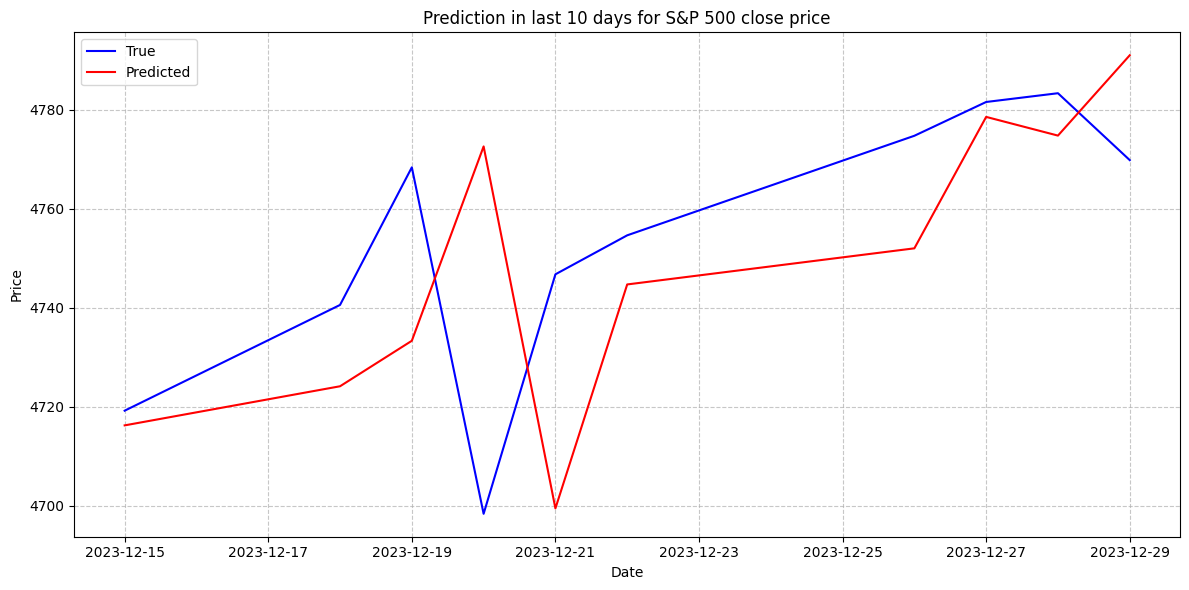

In [48]:
forecast_auto_arima_gspc = model.predict_in_sample(start=len(gspc_close)-10, end=len(gspc_close)-1)

plt.figure(figsize=(12, 6))
plt.plot(gspc_close[-10:].dropna().index, gspc_close[-10:].dropna().values, color='blue', label='True')
plt.plot(gspc_close[-10:].dropna().index, forecast_auto_arima_gspc.dropna().values, color='red', label="Predicted")
plt.title("Prediction in last 10 days for S&P 500 close price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.tight_layout()
plt.show()

In [49]:
print(f"MAE for 10 last samples = {mean_absolute_error(forecast_auto_arima_gspc, gspc_close[-10:])}")

MAE for 10 last samples = 24.146156542099742


Results better thn for diffenced ts in-sample prediction.

Let's go for out-of-sample forecasts.

In [50]:
test_size = 10
train, test = gspc_close[:-test_size], gspc_close[-test_size:]

train.size, test.size

(1499, 10)

In [51]:
model = auto_arima(train, stepwise=True, trace=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=15486.908, Time=3.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=15556.230, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=15542.975, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=15544.485, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=15555.677, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=15542.667, Time=1.28 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=15542.981, Time=0.60 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=15488.605, Time=6.38 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=15545.169, Time=3.37 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=15542.163, Time=0.72 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=15543.357, Time=2.08 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=15544.110, Time=1.90 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=15490.425, Time=7.55 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=15486.578, Time=1.01 sec
 ARIMA(1,1,2)(0,0,0

Again ARIMA(2,1,2) win.

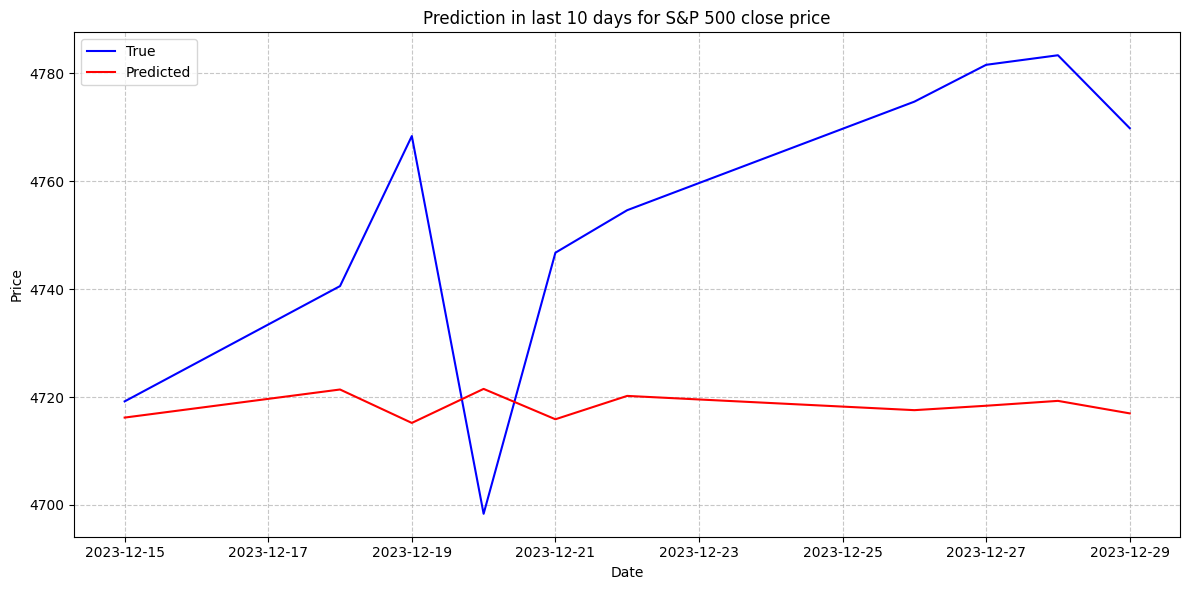

In [52]:
forecast_auto_arima_gspc = model.predict()

plt.figure(figsize=(12, 6))
plt.plot(gspc_close[-10:].dropna().index, gspc_close[-10:].dropna().values, color='blue', label='True')
plt.plot(gspc_close[-10:].dropna().index, forecast_auto_arima_gspc.dropna().values, color='red', label="Predicted")
plt.title("Prediction in last 10 days for S&P 500 close price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.tight_layout()
plt.show()

In [53]:
print(f"MAE for 10 last samples = {mean_absolute_error(forecast_auto_arima_gspc, gspc_close[-10:])}")

MAE for 10 last samples = 40.11274497573804


Hmmm, this result is worse than for differenced ts out-of-sample prediction.

## Regressors

### Apple

The first regressor is dummy one that checks for Apple release day. We can assume that in these days prices can change because of new products.

In [54]:
apple_regr = pd.DataFrame.from_dict({'date' : pd.to_datetime(aapl_close.index)})
apple_regr.head()

,date
0,2018-01-02
1,2018-01-03
2,2018-01-04
3,2018-01-05
4,2018-01-08


In [55]:
apple_release_days = pd.to_datetime([
    '2018-03-27', '2018-06-04', '2018-06-05', '2018-06-06', '2018-06-07', '2018-06-08', '2018-09-12', '2018-10-30',
    '2019-03-25', '2019-06-03', '2019-06-04', '2019-06-05', '2019-06-06', '2019-06-07', '2019-09-10',
    '2020-06-22', '2020-06-23', '2020-06-24', '2020-06-25', '2020-06-26', '2020-09-15', '2020-10-13', '2020-11-10',
    '2021-04-20', '2021-06-07', '2021-06-08', '2021-06-09', '2021-06-10', '2021-06-11', '2021-09-14', '2021-10-18',
    '2022-03-08', '2022-06-06', '2022-06-07', '2022-06-08', '2022-06-09', '2022-06-10', '2022-09-07',
    '2023-06-05', '2023-06-06', '2023-06-07', '2023-06-08', '2023-06-09', '2023-09-12', '2023-10-30'
])

apple_regr['release_days'] = apple_regr['date'].isin(apple_release_days).astype(int)
apple_regr['release_days'].sum()

45

The next dummy predictor is based on "Monday effect". It is worth checking because it is a well-known market anomaly where stock returns on Mondays tend to differ from other days, often showing lower or higher performance due to behavioral and structural factors.

In [56]:
apple_regr['is_monday'] = apple_regr['date'].dt.dayofweek == 0
apple_regr['is_monday'] = apple_regr['is_monday'].astype(int)
apple_regr.head()

,date,release_days,is_monday
0,2018-01-02,0,0
1,2018-01-03,0,0
2,2018-01-04,0,0
3,2018-01-05,0,0
4,2018-01-08,0,1


And also we need some continious regressor. Let's just take the opening price. It is a good idea because it reflects market sentiment, incorporates overnight news, and often correlates strongly with the closing price.

In [57]:
apple_regr['open'] = data_apple['AAPL']['Open'].values
apple_regr = apple_regr.set_index('date')
apple_regr.head()

,release_days,is_monday,open
date,,,
2018-01-02,0,0,42.540001
2018-01-03,0,0,43.132500
2018-01-04,0,0,43.134998
2018-01-05,0,0,43.360001
2018-01-08,0,1,43.587502


Let's make in-sample predictions. We can find (p,d,q) automatically.

In [58]:
model = pm.auto_arima(aapl_close,
                      exogenous=apple_regr[['release_days', 'is_monday', 'open']]
)
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1509
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -3335.725
Date:                Sun, 22 Dec 2024   AIC                           6677.450
Time:                        14:24:06   BIC                           6693.405
Sample:                             0   HQIC                          6683.392
                               - 1509                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0991      0.055      1.815      0.070      -0.008       0.206
ma.L1         -0.0418      0.019     -2.250      0.024      -0.078      -0.005
sigma2         4.8849      0.110     44.248      0.0

So, the best model ARIMAX(0, 1, 1). Let's make predictions.

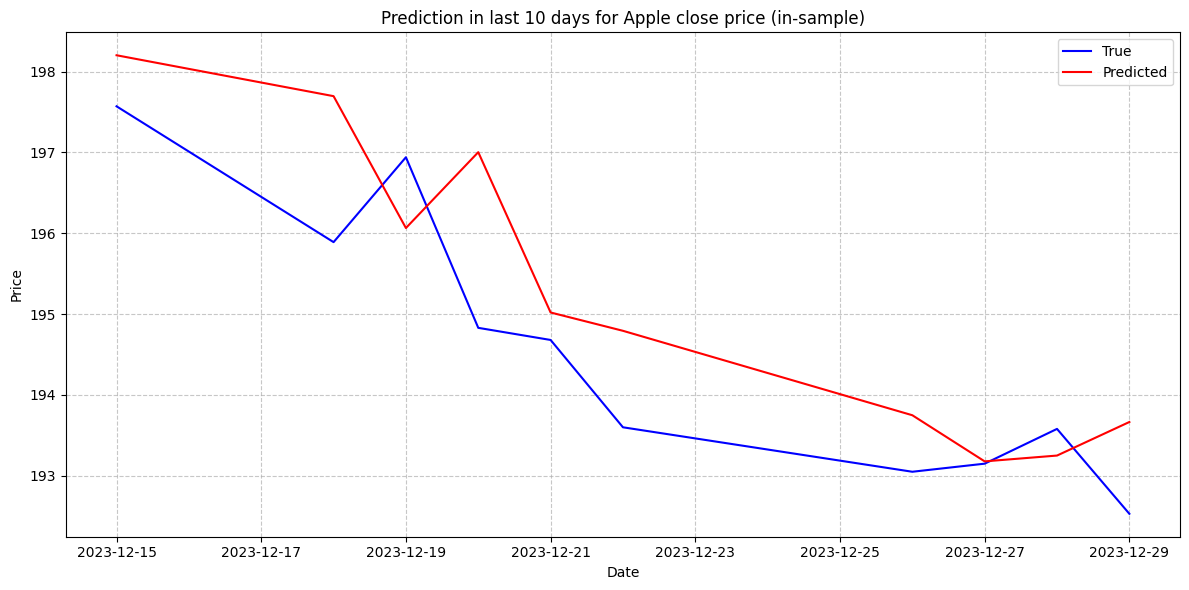

In [59]:
forecast_auto_arima_apple = model.predict_in_sample(start=len(aapl_close)-10, end=len(aapl_close)-1, exog=apple_regr[-10:])

plt.figure(figsize=(12, 6))
plt.plot(aapl_close[-10:].dropna().index, aapl_close[-10:].dropna().values, color='blue', label='True')
plt.plot(aapl_close[-10:].dropna().index, forecast_auto_arima_apple.dropna().values, color='red', label="Predicted")
plt.title("Prediction in last 10 days for Apple close price (in-sample)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.tight_layout()
plt.show()

In [60]:
print(f"MAE for 10 last samples = {mean_absolute_error(forecast_auto_arima_apple, aapl_close[-10:])}")

MAE for 10 last samples = 0.9210609763754235


The results don't change with adding regressors, so they are useless. Now, let's make out-of-sample predictions.

In [61]:
test_size = 10
train, test = aapl_close[:-test_size], aapl_close[-test_size:]

train_regr, test_regr = apple_regr[:-test_size], apple_regr[-test_size:]

train.size, test.size

(1499, 10)

In [62]:
model = pm.auto_arima(train,
                      exogenous=train_regr[['release_days', 'is_monday', 'open']]
)
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1499
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -3317.306
Date:                Sun, 22 Dec 2024   AIC                           6640.611
Time:                        14:24:10   BIC                           6656.547
Sample:                             0   HQIC                          6646.548
                               - 1499                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1035      0.055      1.883      0.060      -0.004       0.211
ma.L1         -0.0417      0.019     -2.234      0.025      -0.078      -0.005
sigma2         4.9091      0.112     44.012      0.0

Again, ARIMAX(0, 1, 1) is the best.

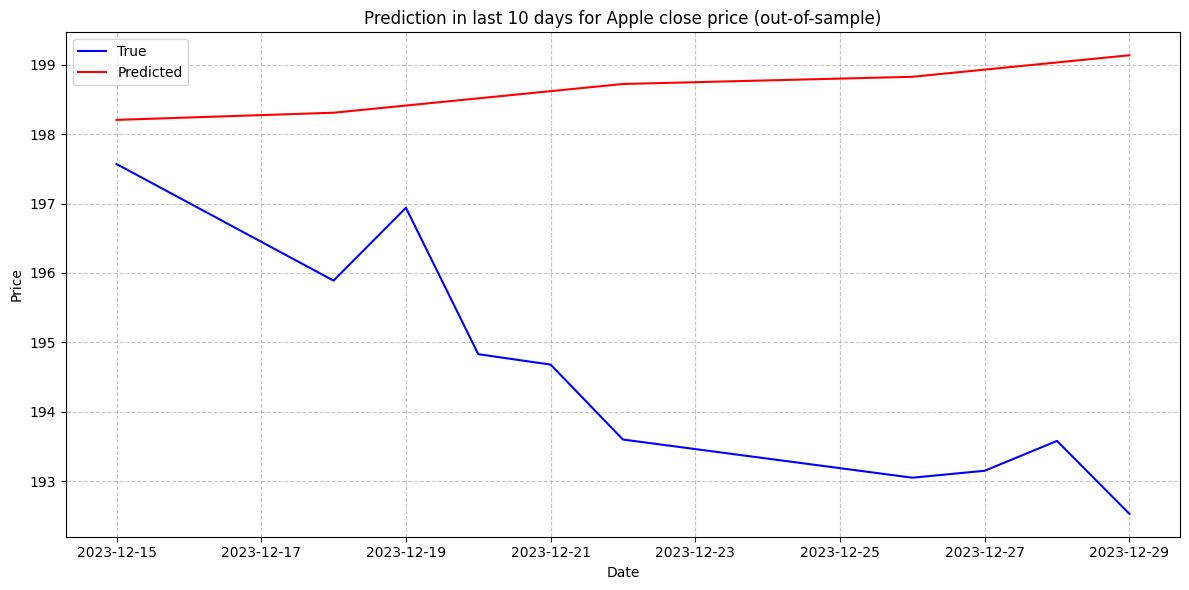

In [63]:
forecast_auto_arima_apple = model.predict_in_sample(start=len(aapl_close)-10, end=len(aapl_close)-1, exog=test_regr)

plt.figure(figsize=(12, 6))
plt.plot(aapl_close[-10:].dropna().index, aapl_close[-10:].dropna().values, color='blue', label='True')
plt.plot(aapl_close[-10:].dropna().index, forecast_auto_arima_apple.dropna().values, color='red', label="Predicted")
plt.title("Prediction in last 10 days for Apple close price (out-of-sample)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.tight_layout()
plt.show()

In [64]:
print(f"MAE for 10 last samples = {mean_absolute_error(forecast_auto_arima_apple, aapl_close[-10:])}")

MAE for 10 last samples = 4.089719374020646


Again, nothing changed :(.

### S&P 500

For this prices firstly I want to check "Friday effect" as a dummy regressor. It is worth investigating because it could reveal potential biases in stock market returns related to the end of the trading week, possibly driven by investor psychology or risk aversion.

In [65]:
gspc_regr = pd.DataFrame.from_dict({'date': pd.to_datetime(gspc_close.index)})
gspc_regr.head()

,date
0,2018-01-02
1,2018-01-03
2,2018-01-04
3,2018-01-05
4,2018-01-08


In [66]:
gspc_regr['is_friday'] = gspc_regr['date'].dt.dayofweek == 4
gspc_regr['is_friday'] = gspc_regr['is_friday'].astype(int)
gspc_regr.head()#.sum()

,date,is_friday
0,2018-01-02,0
1,2018-01-03,0
2,2018-01-04,0
3,2018-01-05,1
4,2018-01-08,0


Let's the second regressor take high value of price in the day. It is a continious regressor and can correlate strongly with the closing price.

In [67]:
gspc_regr['high'] = data_sp500['^GSPC']['High'].values
gspc_regr.head()

,date,is_friday,high
0,2018-01-02,0,2695.889893
1,2018-01-03,0,2714.370117
2,2018-01-04,0,2729.290039
3,2018-01-05,1,2743.449951
4,2018-01-08,0,2748.510010


As a third regressor let's take the low price for consistency with the second regressor.

In [68]:
gspc_regr['low'] = data_sp500['^GSPC']['Low'].values
gspc_regr = gspc_regr.set_index('date')
gspc_regr.head()

,is_friday,high,low
date,,,
2018-01-02,0,2695.889893,2682.360107
2018-01-03,0,2714.370117,2697.770020
2018-01-04,0,2729.290039,2719.070068
2018-01-05,1,2743.449951,2727.919922
2018-01-08,0,2748.510010,2737.600098


Let's go for predictions! First, for in-sample one.

In [69]:
model = pm.auto_arima(gspc_close,
                      exogenous=gspc_regr[['is_friday', 'high', 'low']]
)
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1509
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -7787.845
Date:                Sun, 22 Dec 2024   AIC                          15585.689
Time:                        14:24:50   BIC                          15612.282
Sample:                             0   HQIC                         15595.593
                               - 1509                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7621      0.025    -69.442      0.000      -1.812      -1.712
ar.L2         -0.8860      0.024    -37.324      0.000      -0.933      -0.840
ma.L1          1.6882      0.032     52.093      0.0

Now, the best model is SARIMAX(2, 1, 2). Cool, let's go for predictions.

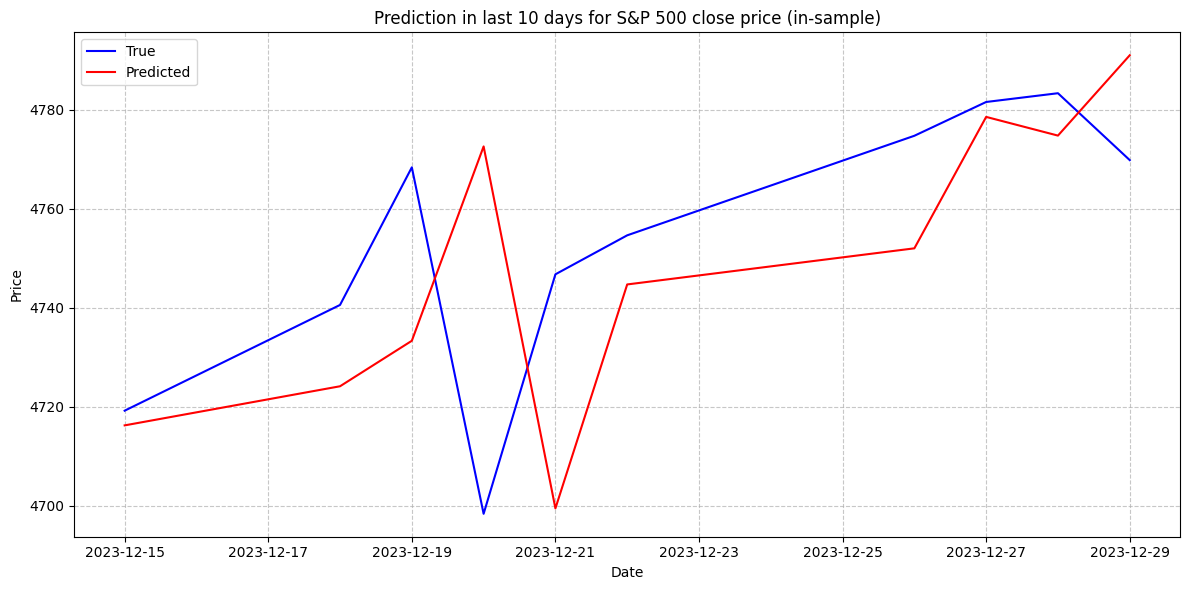

In [70]:
forecast_auto_arima_gspc = model.predict_in_sample(start=len(gspc_close)-10, end=len(gspc_close)-1, exog=gspc_regr[-10:])

plt.figure(figsize=(12, 6))
plt.plot(gspc_close[-10:].dropna().index, gspc_close[-10:].dropna().values, color='blue', label='True')
plt.plot(gspc_close[-10:].dropna().index, forecast_auto_arima_gspc.dropna().values, color='red', label="Predicted")
plt.title("Prediction in last 10 days for S&P 500 close price (in-sample)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.tight_layout()
plt.show()

In [71]:
print(f"MAE for 10 last samples = {mean_absolute_error(forecast_auto_arima_gspc, gspc_close[-10:])}")

MAE for 10 last samples = 24.146156542099742


Again, nothing changed :( with the version without regressors.

In [72]:
test_size = 10
train, test = gspc_close[:-test_size], gspc_close[-test_size:]

train_regr, test_regr = gspc_regr[:-test_size], gspc_regr[-test_size:]

train.size, test.size

(1499, 10)

In [73]:
model = pm.auto_arima(train,
                      exogenous=train_regr[['is_friday', 'high', 'low']]
)
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1499
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -7738.289
Date:                Sun, 22 Dec 2024   AIC                          15486.578
Time:                        14:25:29   BIC                          15513.137
Sample:                             0   HQIC                         15496.473
                               - 1499                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7641      0.025    -70.197      0.000      -1.813      -1.715
ar.L2         -0.8877      0.024    -37.774      0.000      -0.934      -0.842
ma.L1          1.6913      0.032     52.636      0.0

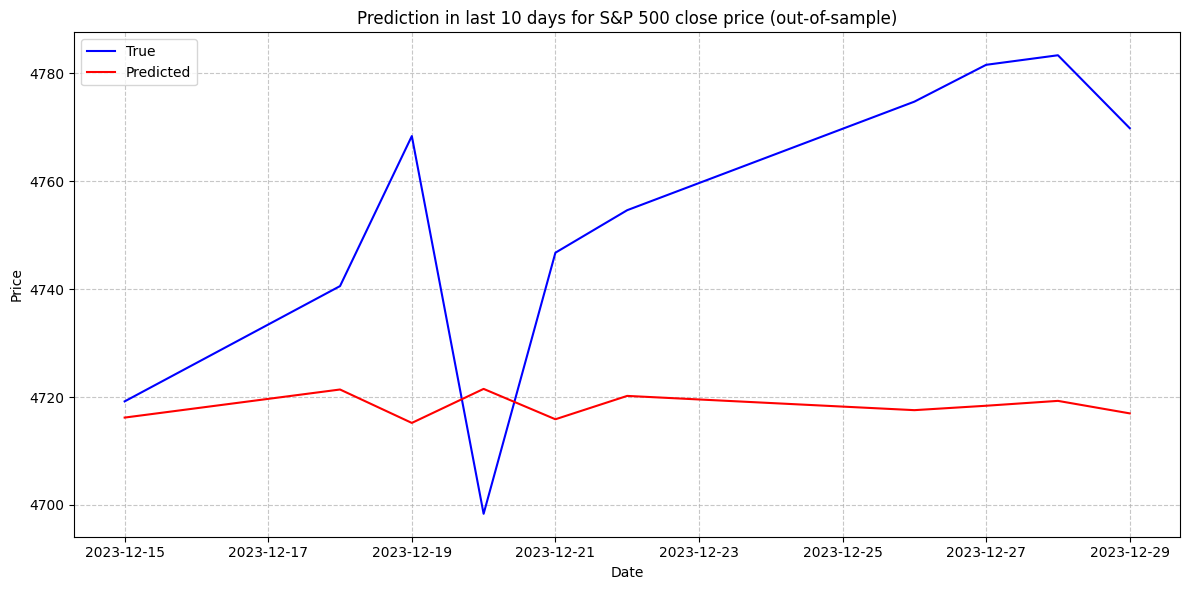

In [74]:
forecast_auto_arima_gspc = model.predict_in_sample(start=len(gspc_close)-10, end=len(gspc_close)-1, exog=test_regr)

plt.figure(figsize=(12, 6))
plt.plot(gspc_close[-10:].dropna().index, gspc_close[-10:].dropna().values, color='blue', label='True')
plt.plot(gspc_close[-10:].dropna().index, forecast_auto_arima_gspc.dropna().values, color='red', label="Predicted")
plt.title("Prediction in last 10 days for S&P 500 close price (out-of-sample)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.tight_layout()
plt.show()

In [75]:
print(f"MAE for 10 last samples = {mean_absolute_error(forecast_auto_arima_gspc, gspc_close[-10:])}")

MAE for 10 last samples = 40.11274497573804


Again, nothing changed :( with the version without regressors.

## Conclusion

The best models is the models from section "Forecasting original data" (I found useless regressors). Check sections for more detailed conclusions.